In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline

In [3]:
train_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\train'
validation_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\valid'

In [4]:
width_shape = 224
height_shape = 224
epochs = 100
num_classes = len(os.listdir(train_data_dir))
batch_size = 32
image_shape = (224,224,3)

Found 12396 images belonging to 24 classes.
Found 2564 images belonging to 24 classes.


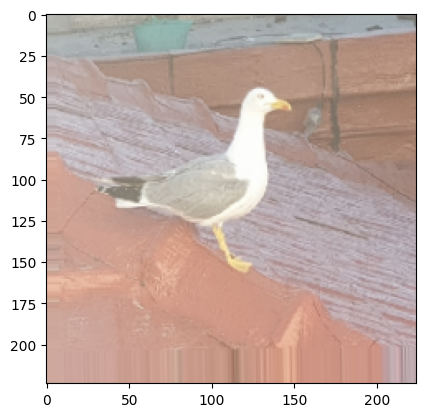

In [5]:
from keras.applications.resnet_v2 import preprocess_input

# Data generators with data augmentation
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(height_shape, width_shape),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(height_shape, width_shape),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

for _ in range(3):
    img, label = next(train_generator)
    plt.imshow(img[0])
    plt.show()

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Flatten, Conv2D, MaxPooling2D

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
import math

custom_efficientnet_model = Sequential([
EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights="imagenet"),
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    Dense(units=512, activation='relu'),
    BatchNormalization(),
    Dense(units=512, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(units=1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(units=num_classes, activation="softmax")
])

custom_efficientnet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print the model summary
custom_efficientnet_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(r'C:\Users\johns\Desktop\TFG\MasCapas\EfficientNetbest_EfficientNet_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Create a dictionary mapping class indices to their respective class weights
class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))

# Calcular steps_per_epoch y validation_steps
num_train_images = train_generator.samples
num_val_images = validation_generator.samples

steps_per_epoch = math.ceil(num_train_images / batch_size)
validation_steps = math.ceil(num_val_images / batch_size)

# Entrena el modelo
hist = custom_efficientnet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weights_dict,  # Pass class weights,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 24)                30744     
                                                                 
Total params: 4,085,435
Trainable params: 4,040,852
Non-

In [ ]:
model.save(r"C:\Users\johns\Desktop\TFG\MasCapas\EfficientNet\custom_EfficientNet_model.h5")

In [ ]:
def plotTraining(hist, epochs, typeData):

    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-b',label='Training Validate')


    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18)
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

In [ ]:
num_epochs_done = len(hist.history['loss'])

plotTraining(hist, num_epochs_done, "loss")
plotTraining(hist, num_epochs_done, "accuracy")
plotTraining(hist, num_epochs_done, "val_loss")
plotTraining(hist, num_epochs_done, "val_accuracy")

In [ ]:
import cv2
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

# nombres de las clases
names = ['AGUJA COLINERA',
          'ALCA COMÚN',
          'AVEFRÍA EUROPEA',
          'AVIÓN ROQUERO',
          'AVOCETA COMÚN',
          'CHARRÁN PATINEGRO',
          'CHORLITO DORADO EUROPEO',
          'ESTORNINO PINTO',
          'FLAMENCO COMUN',
          'FOCHA COMUN',
          'GARCILLA VUEYERA OCCIDENTAL',
          'GAVIOTA PATIAMARILLA',
          'GAVIOTA PICOFINA',
          'GAVIOTA REIDORA',
          'GOLONDRINA COMUN',
          'GORRIÓN COMÚN',
          'GRAJILLA OCCIDENTAL',
          'JILGUERO EUROPEO',
          'MORITO COMÚN',
          'PALOMA TORCAZ',
          'PARDELA BALEAR',
          'PATO CUCHARÓN NORTEÑO',
          'SERÍN VERDECILLO',
          'VENCEJO COMÚN']

# cargar el modelo
modelt = load_model(r"C:\Users\johns\Desktop\TFG\MasCapas\EfficientNet\custom_EfficientNet_model.h5")

# ruta de la imagen
imaget_path = r"C:\Users\johns\Desktop\TFG\Dataset\test\MORITO COMÚN\1105.jpg"

# cargar y redimensionar la imagen
imaget = load_img(imaget_path, target_size=(width_shape, height_shape))
imaget = img_to_array(imaget)
imaget = imaget.reshape((1,) + imaget.shape)

# preprocesar la imagen
xt = imaget / 255.0  # Normalizar la imagen

# hacer predicciones
preds = modelt.predict(xt)

# obtener la clase predicha
predicted_class = np.argmax(preds)
class_name = names[predicted_class]

print(class_name)

# mostrar la imagen
plt.imshow(cv2.cvtColor(imaget.reshape(width_shape, height_shape, 3).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

# Definir el generador de datos de prueba
test_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\test'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(height_shape, width_shape),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Load the model
custom_Model= load_model(r"C:\Users\johns\Desktop\TFG\MasCapas\EfficientNet\custom_EfficientNet_model.h5")

# Make predictions
predictions = custom_Model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_real, y_pred)
plt.figure(figsize=(15, 15))
plot_confusion_matrix(conf_mat=conf_matrix, figsize=(15, 15), class_names=names, show_normed=True)
plt.tight_layout()

# Print classification report
print(classification_report(y_real, y_pred, digits=4))

In [ ]:
print(y_real)

In [ ]:
print(y_pred)